In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import random
from gym import make
import numpy as np
from train import evaluate_policy, QLearning, transform_state
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import itertools

In [2]:
GAMMA = 0.98
GRID_SIZE_X = 30
GRID_SIZE_Y = 30
SEED = 42

In [3]:
def train(alpha=0.1, eps=0.1, episodes=5, name="agent.npy"):
    # alpha = 0.03, eps = 0.0003 best?
    env = make("MountainCar-v0")
    ql = QLearning(state_dim=GRID_SIZE_X * GRID_SIZE_Y, action_dim=3, alpha=alpha)
    transitions = 4_000_000
    trajectory = []
    
    log = {
        "alpha": alpha,
        "eps": eps,
        "episodes": episodes,
        "step": [],
        "mean": [],
        "std": []
    }

    env.seed(SEED)
    env.action_space.seed(SEED)
    
    state_ = env.reset()
    state = transform_state(state_)
    t = tqdm(range(transitions))
    for i in t:
        eps *= (transitions + 1 - i) / transitions
        
        total_reward = 0
        steps = 0

        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = ql.act(state, eps=eps)

        next_state, reward, done, _ = env.step(action)
        # reward += abs(next_state[1]) / 0.07  # not ~
        reward += 300 * (GAMMA * np.abs(next_state[1]) - np.abs(state_[1]))
        done_ = next_state[0] > 0.5
        
        state_ = next_state if not done else env.reset()

        next_state = transform_state(next_state)
        trajectory.append((state, action, next_state, reward, done_))

        if done:
            for transition in reversed(trajectory):
                ql.update(transition)
            trajectory = []

        state = next_state if not done else transform_state(env.reset())

        if (i + 1) % (transitions // 100) == 0:
            rewards = evaluate_policy(ql, episodes)
            
            log["step"].append(i + 1)
            log["mean"].append(np.mean(rewards))
            log["std"].append(np.std(rewards))

            t.set_description(f"step: {i + 1} | Rmean = {np.mean(rewards):0.4f} | Rstd = {np.std(rewards):0.4f}")
            ql.save(name)

    return ql, pd.DataFrame(log)

In [4]:
def plot(**kwargs):
    agent, log = train(**kwargs)
    plt.plot(log["step"], log["mean"], label=f"{kwargs}")
    plt.fill_between(log["step"], log["mean"] - log["std"], log["mean"] + log["std"], alpha=0.5)
    plt.legend()
    plt.show()
    return agent

def plot_collected(log):
    plt.plot(log["step"], log["mean"], label=f"alpha = {log['alpha'][0]} | eps = {log['eps'][0]}")
    plt.fill_between(log["step"], log["mean"] - log["std"], log["mean"] + log["std"], alpha=0.5)
    plt.legend()
    plt.show()

def collect_data(**kwrags):
    return train(**kwrags)[1]

In [5]:
# %%time
# cdd = delayed(collect_data)

# eps_list = np.logspace(-4, 0, 8, endpoint=False)
# alpha_list = np.logspace(-4, 0, 8, endpoint=False)
# eps_alpha_list = []
# for eps in eps_list:
#     for alpha in alpha_list:
#         eps_alpha_list.append((eps, alpha))

# logs = Parallel(n_jobs = 6)(cdd(eps=eps, alpha=alpha) for eps, alpha in eps_alpha_list)

In [6]:
# for log in logs:
#     plot_collected(log)

In [7]:
# %%time
# cdd = delayed(collect_data)
# eps_list = np.logspace(-4, 0, 10, endpoint=False)
# logs = Parallel(n_jobs=6)(cdd(eps=eps, alpha=0.1) for eps in eps_list)
# for log in logs:
#     plot_collected(log)

In [8]:
# %%time
# cdd = delayed(collect_data)
# alpha_list = np.logspace(-4, 0, 10, endpoint=False)
# logs = Parallel(n_jobs=6)(cdd(alpha=alpha, eps=0.0003) for alpha in alpha_list)
# for log in logs:
#     plot_collected(log)

In [9]:
# plot(alpha=0.1, eps=0.1, name="agent.npy", episodes=5)

  0%|          | 0/4000000 [00:00<?, ?it/s]

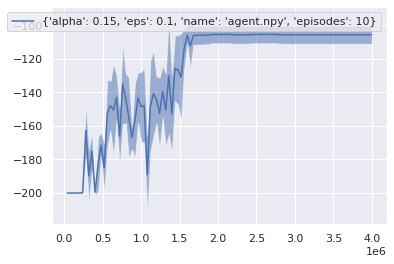

In [10]:
agent = plot(alpha=0.15, eps=0.1, name="agent.npy", episodes=10)

In [12]:
evaluate_policy(agent, episodes=10, to_render=True)

[-109.0, -107.0, -90.0, -107.0, -106.0, -107.0, -109.0, -109.0, -106.0, -107.0]